In [97]:
from tensorflow import keras
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import do_mpc
import pandas as pd
import os

In [98]:
file_list = os.listdir('./results/')
n_res = len(file_list)

In [99]:
nn_input_list = []
nn_output_list = []
for file_i in file_list:
    res = do_mpc.data.load_results('./results/'+file_i)

    phi = res['simulator']['_x', 'phi'].flatten()
    theta = res['simulator']['_x', 'theta'].flatten()
    u_tilde = res['simulator']['_u', 'u_tilde'].flatten()
    psi = res['simulator']['_x', 'psi'].flatten()
    E_0 = res['simulator']['_p', 'E_0'].flatten()
    v_0 = res['simulator']['_p', 'v_0'].flatten()
    
    phi += 0.01*np.random.rand(phi.shape[0])
    theta += 0.01*np.random.rand(theta.shape[0])
    
    phi = np.roll(phi, -1)
    theta = np.roll(theta, -1)
    psi = np.roll(psi, -1)
    
    phi = phi[:-1]
    theta = theta[:-1]
    u_tilde = u_tilde[:-1]
    psi = psi[:-1]
    E_0 = E_0[:-1]
    v_0 = v_0[:-1]

    nn_input = {'phi':phi, 'theta': theta, 'u_tilde': u_tilde}
    nn_output = {'phi':phi, 'theta': theta, 'psi': psi,  'u_tilde': u_tilde, 'E_0': E_0, 'v_0': v_0}

    nn_input_df = pd.DataFrame.from_dict(nn_input)
    nn_output_df = pd.DataFrame.from_dict(nn_output)

    nn_input_list.append(nn_input_df)
    nn_output_list.append(nn_output_df)

## RNN I/O structure
All our recurrent neural networks are trained with the stateful setting **True**. The settings is explained [here](https://keras.io/examples/lstm_stateful/). In summary, after having trained on a given data sequence, we use the resulting hidden state to initialize the next sequence. This is beneficial, when a very long coherent sequence is chopped into chunks for training (due to memory restrictions). In practice this allows to train the network to incoroporate much older information than the horizon, as defined with `seq_length`, contains. 

The downside of stateful training is, that data pre-processing is becoming more complex, when using batches. 
In the code cell below, we are preparing the data for stateful training with `batch_size > 0`.

In [100]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = model_selection.train_test_split(nn_input_list, nn_output_list)

In [177]:
n_datasets = len(nn_input_train)
seq_length = 20  # length of sequence for ANN training

n_data = nn_input_train[0].shape[0]
n_seq = n_data // seq_length

# create sequences from the data:
X = []
Y = []
# for data_i in range(n_datasets):
#     X_train = nn_input_train[data_i].to_numpy()
#     Y_train = nn_output_train[data_i].to_numpy()
#     for offset in range(seq_length):
#         for data_sample in range(n_seq-1):
#             start_ind = data_sample*seq_length+offset
#             X.append(X_train[start_ind:start_ind + seq_length, :])
#             Y.append(Y_train[start_ind:start_ind + seq_length, :])

for data_sample in range(n_seq):
    for data_i in range(n_datasets):
        X_train = nn_input_train[data_i].to_numpy()
        Y_train = nn_output_train[data_i].to_numpy()
        for offset in range(seq_length):
            start_ind = data_sample*seq_length+offset
            X.append(X_train[start_ind:start_ind + seq_length, :])
            Y.append(Y_train[start_ind:start_ind + seq_length, :])

X = np.stack(X, axis=0)  # [m, seq_length, nx]
Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

batch_size = seq_length*n_datasets
nx = X.shape[2]
ny = Y.shape[2]

In [178]:
batch_size

300

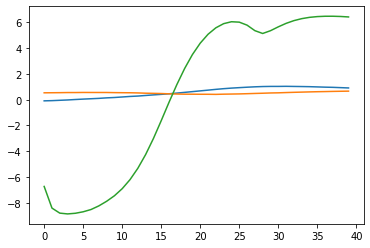

In [184]:
n= 80
plt.plot(np.concatenate((X[0+n],X[batch_size+n])))

We obtain the following training data shape:

In [185]:
X.shape

(10200, 20, 3)

Note that with the batch_size:

In [186]:
batch_size

300

WE obtain

In [187]:
X.shape[0]/batch_size

34.0

consecutive sequences for each batch.

# Create RNN:

In [188]:
def get_model(model_param, nx, ny, batch_size, seq_length, stateful=True, return_sequences=True):
    n_a = model_param['RNN_param']['n_activation']

    implementation_mode = model_param['RNN_param']['implementation']

    model = keras.models.Sequential()
    if 'SimpleRNN' in model_param['RNN_param']['RNN_type']:
        model.add(keras.layers.SimpleRNN(n_a, input_shape=(seq_length, nx), batch_size=batch_size,
                                         return_sequences=return_sequences, stateful=stateful))
    elif 'GRU' in model_param['RNN_param']['RNN_type']:
        model.add(keras.layers.GRU(n_a, input_shape=(seq_length, nx), recurrent_activation='sigmoid', batch_size=batch_size,
                                   return_sequences=return_sequences, stateful=stateful, implementation=implementation_mode))
    elif 'LSTM' in model_param['RNN_param']['RNN_type']:
        model.add(keras.layers.LSTM(n_a, input_shape=(seq_length, nx), recurrent_activation='sigmoid', batch_size=batch_size,
                                    return_sequences=return_sequences, stateful=stateful, implementation=implementation_mode))

    for units, activation in zip(model_param['n_units'], model_param['activation']):
        model.add(keras.layers.TimeDistributed(keras.layers.Dense(units, activation=activation)))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(ny, activation='linear')))
    return model

In [189]:
stateful = True
n_layer = 3  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [40]
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 30
model_param['RNN_param']['implementation'] = 2

model = get_model(model_param, nx, ny, batch_size=batch_size,
                  seq_length=seq_length, stateful=stateful)

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (300, 20, 30)             4080      
_________________________________________________________________
time_distributed_68 (TimeDis (300, 20, 40)             1240      
_________________________________________________________________
time_distributed_69 (TimeDis (300, 20, 40)             1640      
_________________________________________________________________
time_distributed_70 (TimeDis (300, 20, 40)             1640      
_________________________________________________________________
time_distributed_71 (TimeDis (300, 20, 6)              246       
Total params: 8,846
Trainable params: 8,846
Non-trainable params: 0
_________________________________________________________________


In [202]:
cb_reset = keras.callbacks.LambdaCallback(on_epoch_end=model.reset_states())

history = model.fit(X, Y, callbacks=[cb_reset], batch_size=batch_size,
          epochs=100, verbose=1, shuffle=False)

Train on 10200 samples
Epoch 1/100
10200/10200 [==============================] - 1s 66us/sample - loss: 0.4808
Epoch 2/100
10200/10200 [==============================] - 1s 67us/sample - loss: 0.1653
Epoch 3/100
10200/10200 [==============================] - 1s 71us/sample - loss: 0.1053
Epoch 4/100
10200/10200 [==============================] - 1s 71us/sample - loss: 0.0983
Epoch 5/100
10200/10200 [==============================] - 1s 69us/sample - loss: 0.0903
Epoch 6/100
10200/10200 [==============================] - 1s 66us/sample - loss: 0.0957
Epoch 7/100
10200/10200 [==============================] - 1s 69us/sample - loss: 0.0937
Epoch 8/100
10200/10200 [==============================] - 1s 71us/sample - loss: 0.0917
Epoch 9/100
10200/10200 [==============================] - 1s 70us/sample - loss: 0.0891
Epoch 10/100
10200/10200 [==============================] - 1s 66us/sample - loss: 0.0900
Epoch 11/100
10200/10200 [==============================] - 1s 70us/sample - loss: 0.0

10200/10200 [==============================] - 1s 71us/sample - loss: 0.0728
Epoch 92/100
10200/10200 [==============================] - 1s 68us/sample - loss: 0.0715
Epoch 93/100
10200/10200 [==============================] - 1s 70us/sample - loss: 0.0711
Epoch 94/100
10200/10200 [==============================] - 1s 65us/sample - loss: 0.0705
Epoch 95/100
10200/10200 [==============================] - 1s 64us/sample - loss: 0.0708
Epoch 96/100
10200/10200 [==============================] - 1s 64us/sample - loss: 0.0707
Epoch 97/100
10200/10200 [==============================] - 1s 65us/sample - loss: 0.0717
Epoch 98/100
10200/10200 [==============================] - 1s 68us/sample - loss: 0.0706
Epoch 99/100
10200/10200 [==============================] - 1s 97us/sample - loss: 0.0706
Epoch 100/100
10200/10200 [==============================] - 1s 72us/sample - loss: 0.0700


# Evaluate Model
To evaluate the model, we create a similar structure but with `seq_length=1` and `batch_size=1`. The weights are taken from the trained model. This model can be evaluated recursiveley (with a single sequence element as input) and keeps track of the hidden state itself.

In [203]:
model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=stateful)

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (1, 1, 30)                4080      
_________________________________________________________________
time_distributed_76 (TimeDis (1, 1, 40)                1240      
_________________________________________________________________
time_distributed_77 (TimeDis (1, 1, 40)                1640      
_________________________________________________________________
time_distributed_78 (TimeDis (1, 1, 40)                1640      
_________________________________________________________________
time_distributed_79 (TimeDis (1, 1, 6)                 246       
Total params: 8,846
Trainable params: 8,846
Non-trainable params: 0
_________________________________________________________________


In [213]:
model_simple.reset_states()
test_with = 3
nn_input_i = nn_input_test[test_with]
nn_output_i = nn_output_test[test_with]


res = []

for i,in_i in nn_input_i.iterrows():
    rnn_in = in_i.to_numpy().reshape(1,-1)
    #rnn_in *= (1+0.1*np.random.randn(rnn_in.shape[0]))
    rnn_out = model_simple.predict(rnn_in.reshape(1,1,-1))
    res.append(rnn_out)
res = np.concatenate(res, axis=0).squeeze()

In [214]:
res_df = pd.DataFrame(res, columns = nn_output_i.keys())

Text(0, 0.5, 'v_0')

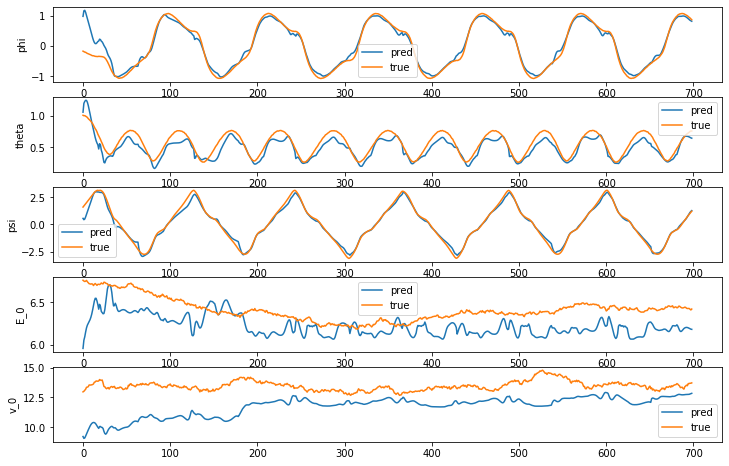

In [215]:
fig, ax = plt.subplots(5, figsize=(12,8))

res_df.plot(y=['phi'], ax=ax[0], label=['pred'])
nn_output_i.plot(y=['phi'], ax=ax[0], label=['true'])
ax[0].set_ylabel('phi')

res_df.plot(y=['theta'], ax=ax[1], label=['pred'])
nn_output_i.plot(y=['theta'], ax=ax[1], label=['true'])
ax[1].set_ylabel('theta')

res_df.plot(y=['psi'], ax=ax[2], label=['pred'])
nn_output_i.plot(y=['psi'], ax=ax[2], label=['true'])
ax[2].set_ylabel('psi')

res_df.plot(y=['E_0'], ax=ax[3], label=['pred'])
nn_output_i.plot(y=['E_0'], ax=ax[3], label=['true'])
ax[3].set_ylabel('E_0')

res_df.plot(y=['v_0'], ax=ax[4], label=['pred'])
nn_output_i.plot(y=['v_0'], ax=ax[4], label=['true'])
ax[4].set_ylabel('v_0')